In [1]:
import uproot
import numpy as np
import ROOT
import itertools
from array import array
ROOT.gROOT.SetStyle('ATLAS')
import time
import os
from IPython.display import Image, display

def draw_note(x, y, text, size=35, font=63):
    l = ROOT.TLatex()
    l.SetNDC()
    l.SetTextColor(1)
    l.SetTextFont(font)
    l.SetTextSize(size);
    l.DrawLatex(x, y, text)

def atlas_label(x, y, text=None, color=1):
    draw_note(x, y, r"#bf{#it{ATLAS}} " + text)

FONT_SIZE = 30

Welcome to JupyROOT 6.20/04


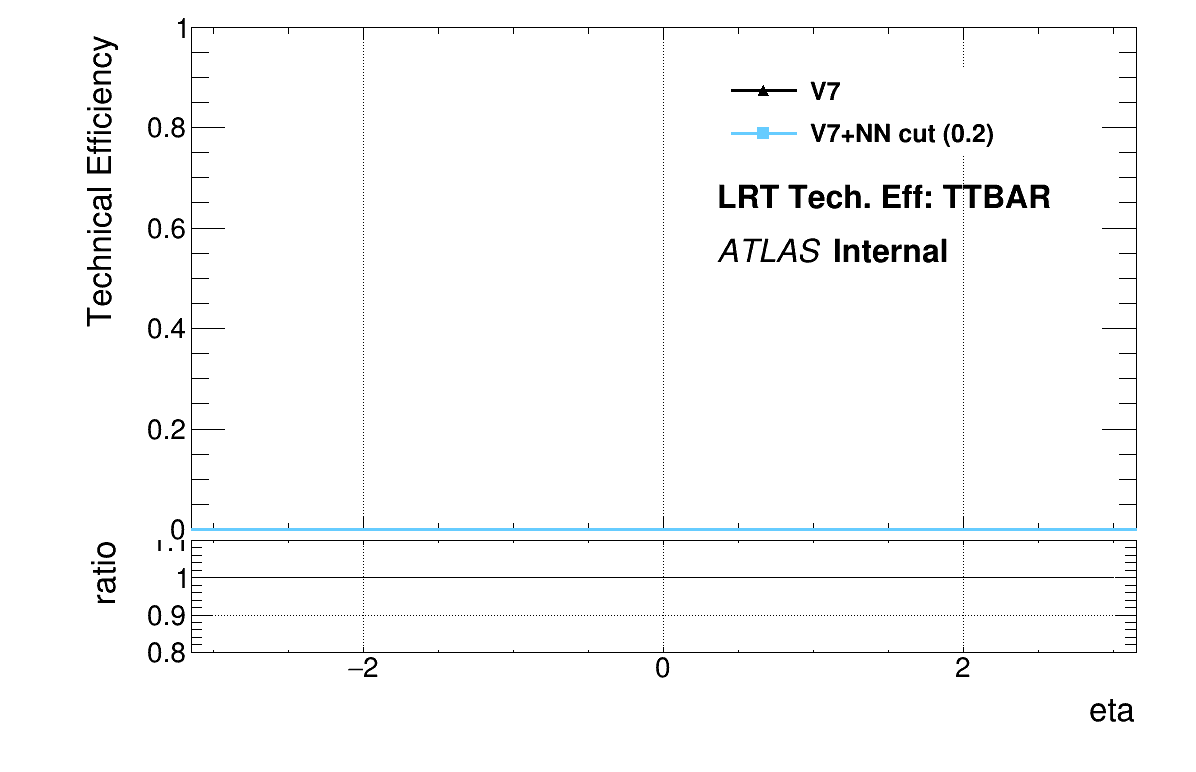

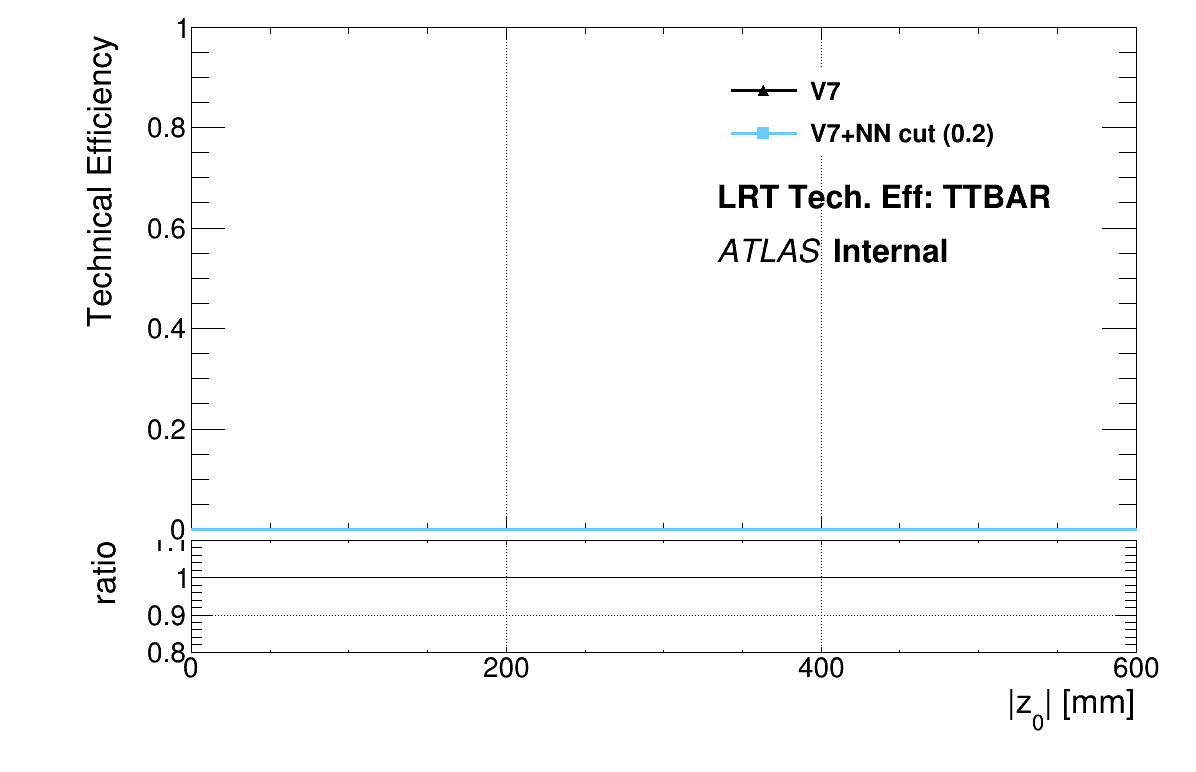

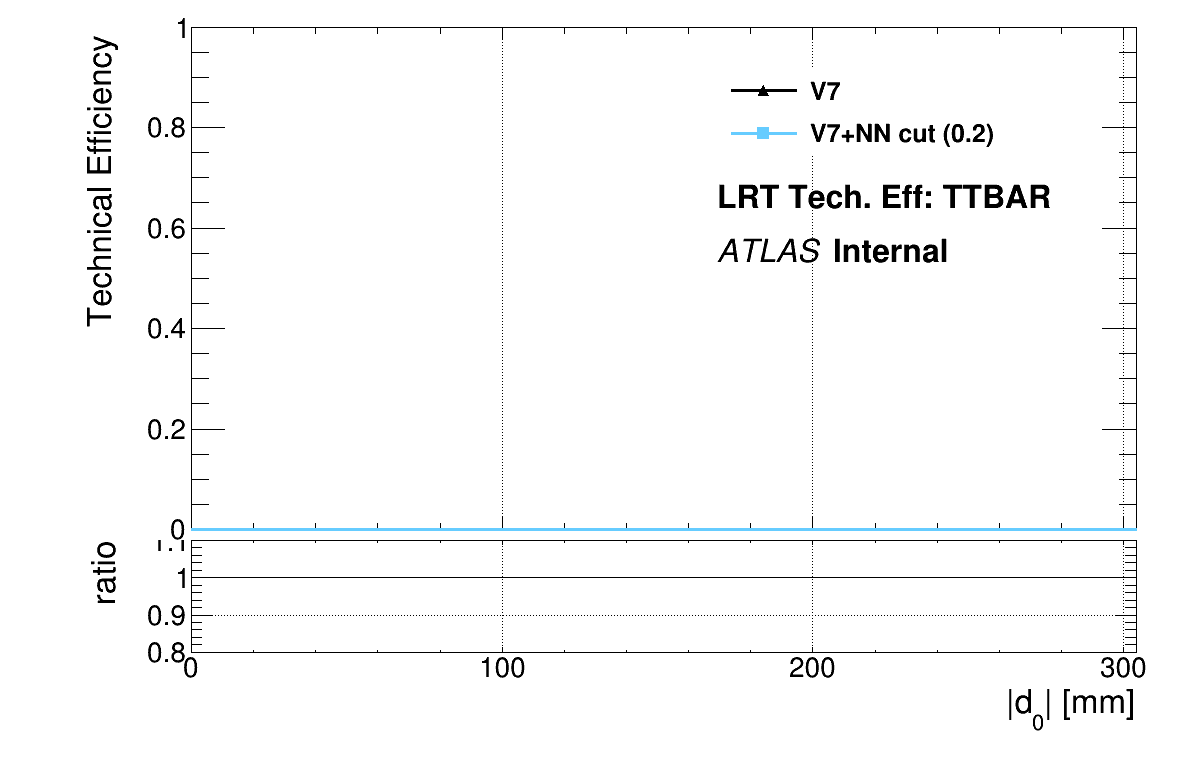

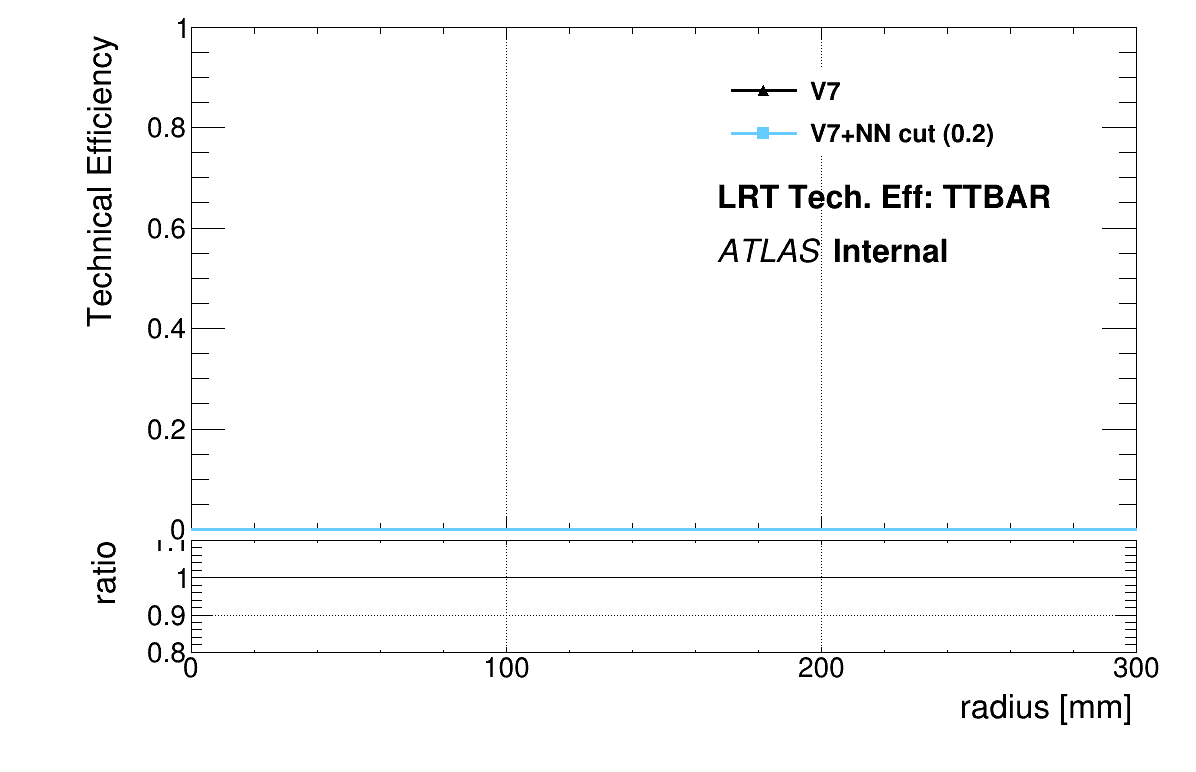

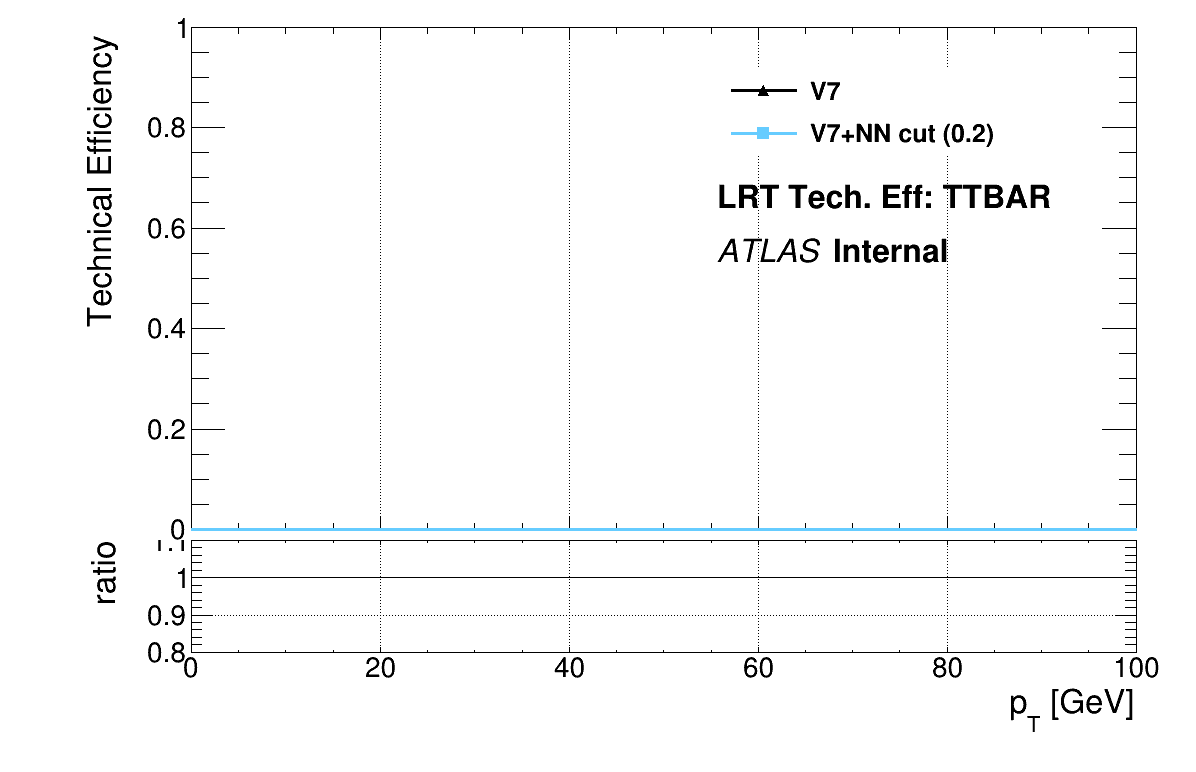

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /data/newhouse/LRT/forMatthias/plots/v7_nn_p2/TTBAR/tech_eff_comparison_truth_eta.png has been created
Info in <TCanvas::Print>: pdf file /data/newhouse/LRT/forMatthias/plots/v7_nn_p2/TTBAR/tech_eff_comparison_truth_eta.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /data/newhouse/LRT/forMatthias/plots/v7_nn_p2/TTBAR/tech_eff_comparison_truth_absz0.png has been created
Info in <TCanvas::Print>: pdf file /data/newhouse/LRT/forMatthias/plots/v7_nn_p2/TTBAR/tech_eff_comparison_truth_absz0.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /data/newhouse/LRT/forMatthias/plots/v7_nn_p2/TTBAR/tech_eff_comparison_truth_absd0.png has been created
Info in <TCanvas::Print>: pdf file /data/newhouse/LRT/forMatthias/plots/v7_nn_p2/TTBAR/tech_eff_c

In [24]:
signal = 'VH4b'
signal = 'HNL'
signal = 'RPVLF'
signal = 'TTBAR'

variables = {
    'truth_eta' :   {'bounds' : (-3,3),    'label': 'eta', 'log' : False,},
    'truth_absz0' : {'bounds' : (0,600), 'label': '|z_{0}| [mm]', 'log' : False,},
    'truth_absd0' : {'bounds' : (0,300),   'label': '|d_{0}| [mm]', 'log' : False,},
    'truth_r' :     {'bounds' : (0,300),  'label': 'radius [mm]', 'log' : False,},
    'truth_pt' :    {'bounds' : (0,100),   'label': 'p_{T} [GeV]', 'log' : False,},
}
output_dir = f"/data/newhouse/LRT/forMatthias/plots/v7_nn_p2/{signal}/"
os.makedirs(output_dir, exist_ok=True)

for var, options in variables.items():
    # bins = [2, 2.5, 3, 4, 6, 8, 10]
    hist_markers = itertools.cycle([22,21,33,29,30,31,32,34,35])
    hist_colors = itertools.cycle([ROOT.kBlack, ROOT.kAzure+6, ROOT.kRed, ROOT.kViolet+8, ROOT.kGreen+1, ROOT.kOrange -3])
    tree_name = 'Efficiency'
    tree1 = 'v7'
    tree2 = 'v7_nn'
    # Open file
    tfiles = {tree1: ROOT.TFile(f'/home/newhouse/public/Analysis/LRT/lrtanalysis/run/plots/Efficiency_files_{signal}_V7.root'),
              tree2: ROOT.TFile(f'/home/newhouse/public/Analysis/LRT/lrtanalysis/run/plots/Efficiency_files_{signal}_V7nn_p2.root')}

    # Load tree from file
    ttree = {tree1:  tfiles[tree1].Get(tree_name),
             tree2:  tfiles[tree2].Get(tree_name)}

    hist =  {tree1 : ttree[tree1].Get(var),
            tree2 : ttree[tree2].Get(var),}

    # Upper plot will be in pad1
    c = None
    scale = 1.0
    c = ROOT.TCanvas("c", "", int(1200*scale), int(800*scale))

    pad1 = ROOT.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
    pad1.SetBottomMargin(0.02);  # Upper and lower plot are not joined
    pad1.SetGridx();          # Vertical grid
    pad1.Draw();              # Draw the upper pad: pad1
    pad1.cd();                # pad1 becomes the current pad

        
    # Set draw properties
    for key, h in hist.items():
        # Histogram properties
        h.SetMarkerSize(1.5*scale)
        h.SetLineWidth(int(3*scale))
        hcolor = next(hist_colors)
        h.SetLineColor(hcolor)
        h.SetMarkerColor(hcolor)
        h.SetMarkerStyle(next(hist_markers))
        # X axis
        h.GetXaxis().SetRangeUser(options['bounds'][0], options['bounds'][1]);
        h.GetXaxis().SetLabelSize(0);
        h.GetXaxis().SetTitle(options['label'])
        h.GetYaxis().SetTitle("Technical Efficiency")
        # Y axis
        h.GetYaxis().SetMaxDigits(6);
        h.GetYaxis().SetTitleOffset(1.0)
        h.GetYaxis().SetRangeUser(0,1);
        h.GetYaxis().SetLabelFont(43);  # Absolute font size in pixel (precision 3)
        h.GetYaxis().SetLabelSize(FONT_SIZE);   
        h.GetYaxis().SetTitleFont(43)  # Absolute font size in pixel (precision 3)
        h.GetYaxis().SetTitleSize(FONT_SIZE*1.2)
    
    hist[tree1].Draw()
    hist[tree2].Draw("SAME")
    c.cd();
    # format legend
    x = 0.6
    y = 0.8
    leg = ROOT.TLegend(x, 0.8, 0.91, 0.91)
    leg.SetTextSize(0.035)
    leg.SetBorderSize(0)
    leg.SetFillColor(ROOT.kWhite)
    leg.SetShadowColor(ROOT.kWhite)
    leg.AddEntry(hist[tree1], "V7", "lp")
    leg.AddEntry(hist[tree2], "V7+NN cut (0.2)", "lp")
    dy = .07
    draw_note(x, y-dy, f'LRT Tech. Eff: {signal}')
    atlas_label(x,y-2*dy, 'Internal')
#     draw_note(x, y-3*dy, signal)
    leg.Draw()


    # lower plot will be in pad 2
    c.cd();          # Go back to the main canvas before defining pad2
    pad2 = ROOT.TPad("pad2", "pad2", 0, 0.05, 1, 0.3)
    pad2.SetTopMargin(0)
    pad2.SetBottomMargin(0.42)
    pad2.SetGridx() # vertical grid
    pad2.SetGridy() # horizontal grid
    pad2.Draw()
    pad2.cd() # pad2 becomes the current pad
    
    # Define the ratio plot
    h3 = hist[tree2].Clone("h3");
    h3.SetLineColor(hcolor);
    h3.SetMinimum(0.8);  # Define Y ..
    h3.SetMaximum(1.1); # .. range
#     h3.Sumw2();
#     h3.SetStats(0);      # No statistics on lower plot
    h3.Divide(hist[tree1]);
    h3.SetMarkerStyle(21);
    max_bin_content = h3.GetBinContent(h3.GetMaximumBin())
    min_bin_content = h3.GetBinContent(h3.GetMinimumBin())
#     h3.SetMaximum(1.4 if max_bin_content > 1.3 else max_bin_content + .1);
#     h3.SetMinimum(min_bin_content - .1);
    hline = ROOT.TLine(options['bounds'][0], 1, options['bounds'][1], 1)
    pad2.SetFillStyle(0)
    h3.Draw("ep") # Draw the ratio plot 
    hline.Draw("Same")
    h3.Draw("ep Same") # Draw the ratio plot 

    # Y axis ratio plot settings
    h3.GetYaxis().SetTitle("ratio")
    h3.GetYaxis().SetNdivisions(505)
    h3.GetYaxis().SetTitleSize(FONT_SIZE*1.2)
    h3.GetYaxis().SetTitleFont(43)
    h3.GetYaxis().SetTitleOffset(1.0)
    h3.GetYaxis().SetLabelFont(43)  # Absolute font size in pixel (precision 3)
    h3.GetYaxis().SetLabelSize(FONT_SIZE)
    # X axis ratio plot settings
    h3.GetXaxis().SetTitleSize(FONT_SIZE*1.2);
    h3.GetXaxis().SetTitleFont(43);
    h3.GetXaxis().SetTitleOffset(4.);
    h3.GetXaxis().SetLabelFont(43);  # Absolute font size in pixel (precision 3)
    h3.GetXaxis().SetLabelSize(FONT_SIZE);  
    
    
#     c.Draw()
    image_file = f'{output_dir}tech_eff_comparison_{var}.png'
    c.SaveAs(image_file)
    c.SaveAs(image_file.replace('png', 'pdf'))
    display(Image(filename=image_file))

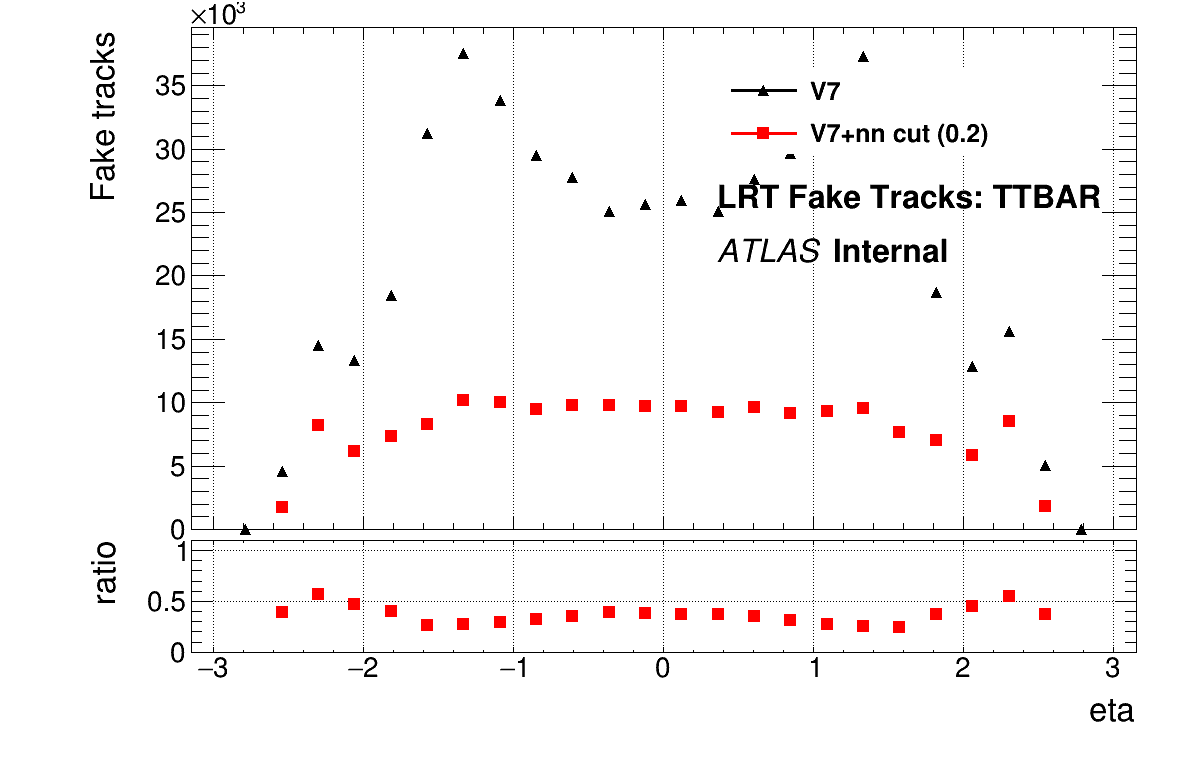

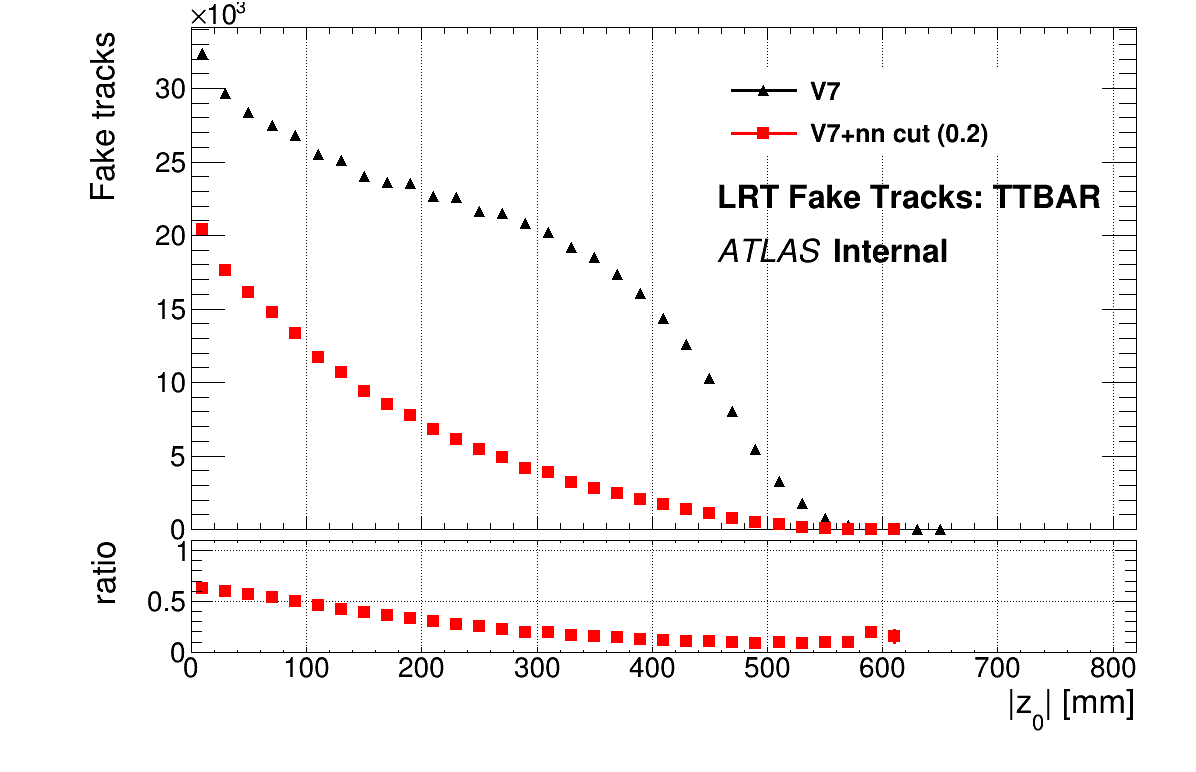

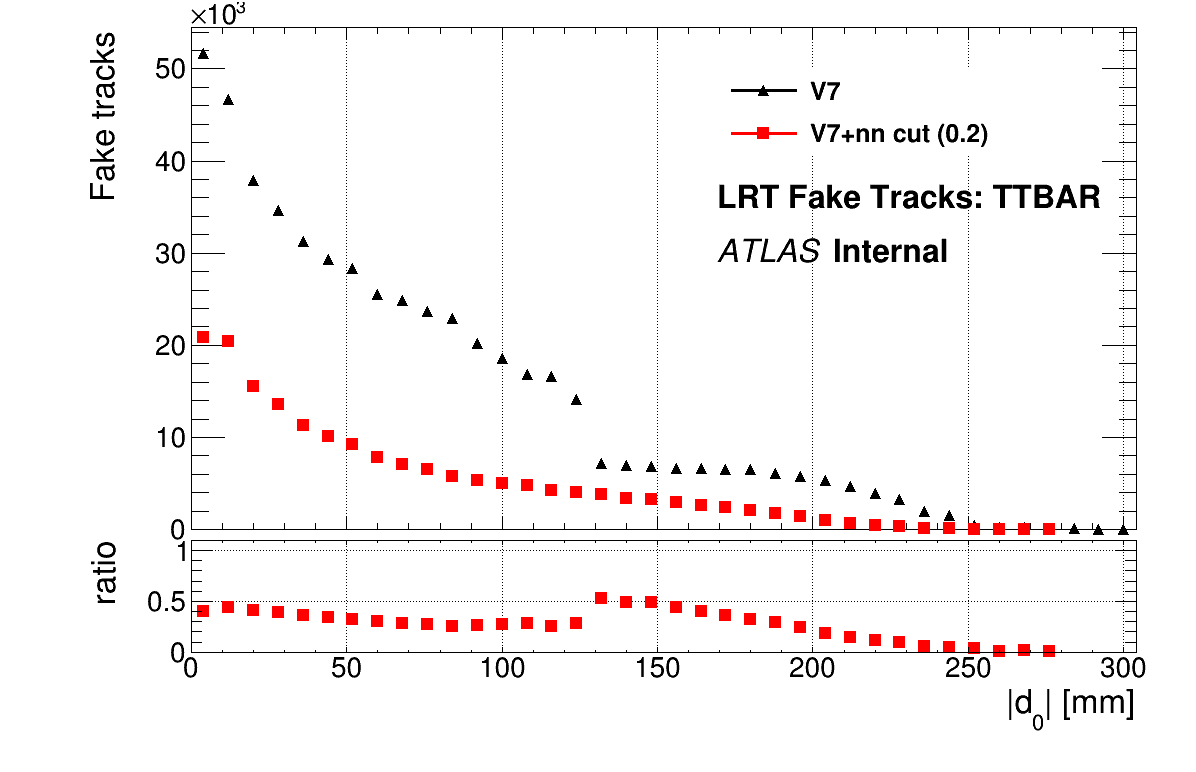

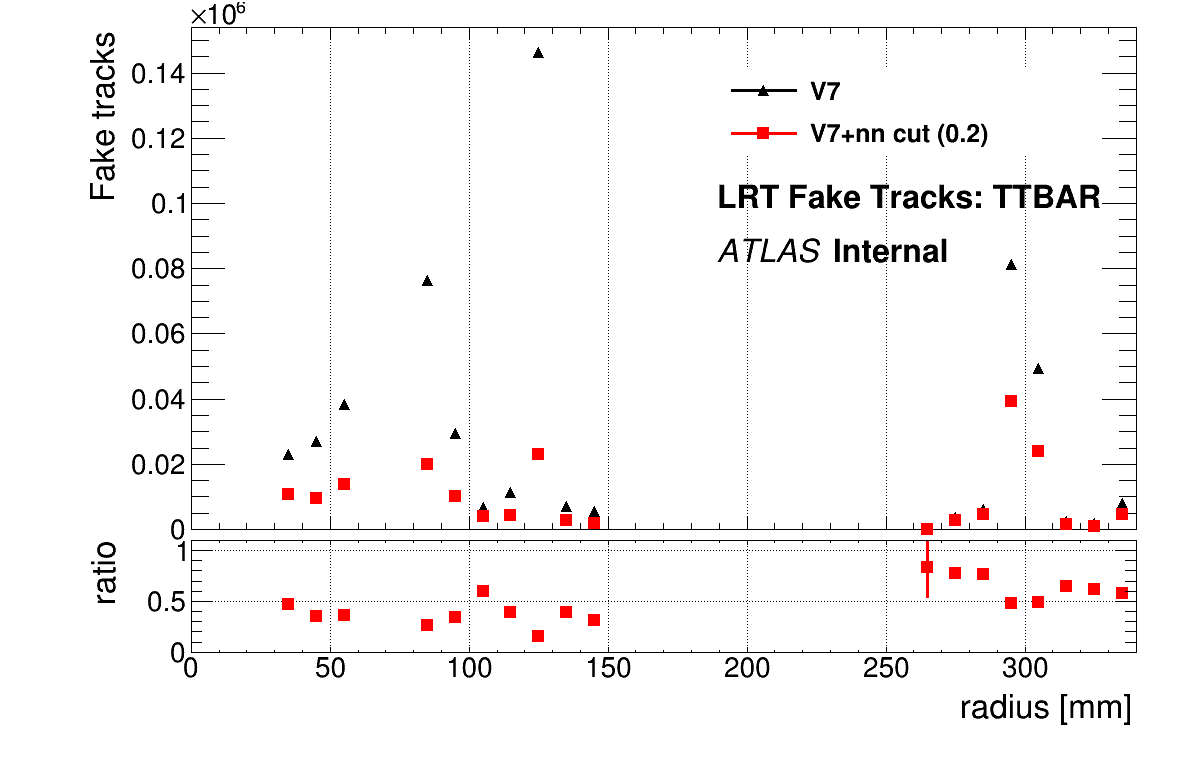

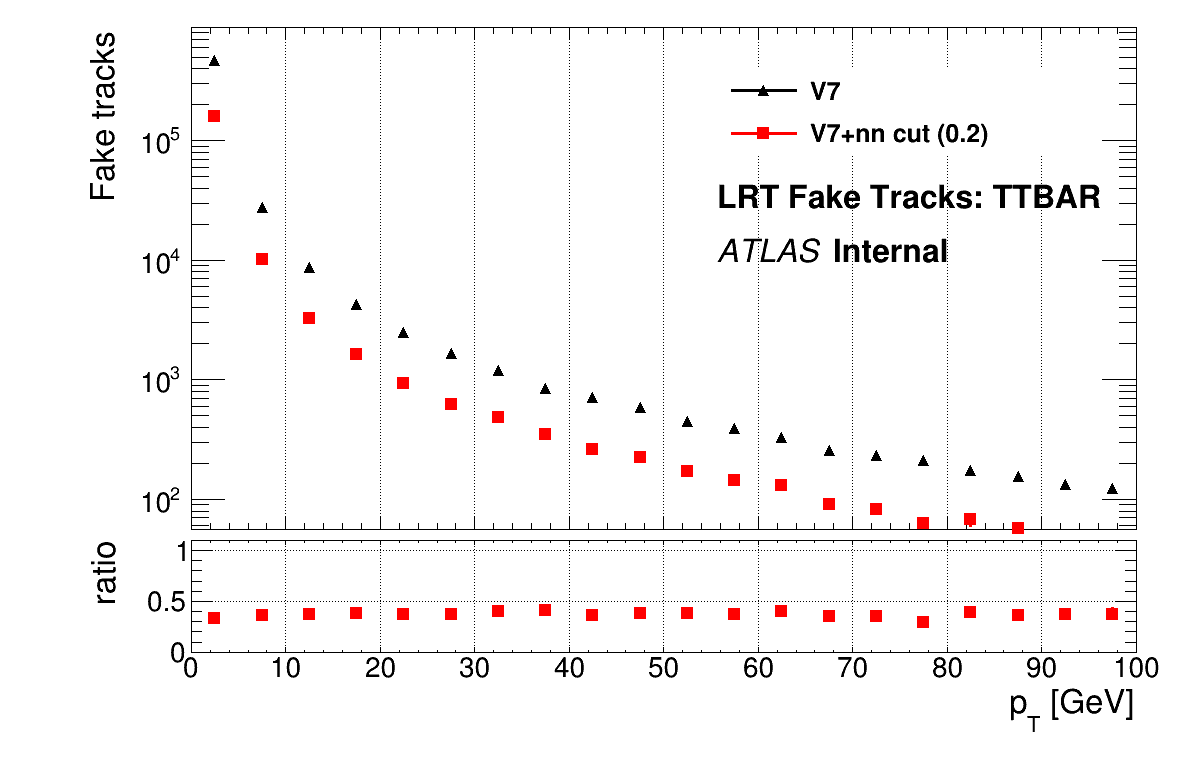

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /data/newhouse/LRT/forMatthias/plots/v7_nn_p2/TTBAR/fakes_track_eta.png has been created
Info in <TCanvas::Print>: pdf file /data/newhouse/LRT/forMatthias/plots/v7_nn_p2/TTBAR/fakes_track_eta.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /data/newhouse/LRT/forMatthias/plots/v7_nn_p2/TTBAR/fakes_track_absz0.png has been created
Info in <TCanvas::Print>: pdf file /data/newhouse/LRT/forMatthias/plots/v7_nn_p2/TTBAR/fakes_track_absz0.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /data/newhouse/LRT/forMatthias/plots/v7_nn_p2/TTBAR/fakes_track_absd0.png has been created
Info in <TCanvas::Print>: pdf file /data/newhouse/LRT/forMatthias/plots/v7_nn_p2/TTBAR/fakes_track_absd0.pdf has been created
Warning in <TCanvas::Constructor>: Deleti

In [25]:
# Make fake comparison plot

variables = {
    'track_eta' :   {'bounds' : (-3,3),    'label': 'eta', 'log' : False,},
    'track_absz0' : {'bounds' : (0,10000), 'label': '|z_{0}| [mm]', 'log' : False,},
    'track_absd0' : {'bounds' : (0,300),   'label': '|d_{0}| [mm]', 'log' : False,},
    'track_r' :     {'bounds' : (0,1000),  'label': 'radius [mm]', 'log' : False,},
    'track_pt' :    {'bounds' : (0,100),   'label': 'p_{T} [GeV]', 'log' : True,},
}
# output_dir = f"/home/newhouse/public/Analysis/LRT/lrtanalysis/run/NN_func/{signal}/"
# os.makedirs(output_dir, exist_ok=True)

for var, options in variables.items():
    # bins = [2, 2.5, 3, 4, 6, 8, 10]
    hist_markers = itertools.cycle([22,21,33,29,30,31,32,34,35])
    hist_colors = itertools.cycle([ROOT.kBlack ,ROOT.kRed, ROOT.kAzure+6, ROOT.kViolet+8, ROOT.kGreen+1, ROOT.kOrange -3])
    tree_name = 'TrackIsFakeIsLRTPassSelection0'
    tree1 = 'v7'
    tree2 = 'v7_mod'
    # Open file
    tfiles = {tree1: ROOT.TFile(f'/home/newhouse/public/Analysis/LRT/lrtanalysis/run/output/files_{signal}_V7.root'),
              tree2: ROOT.TFile(f'/home/newhouse/public/Analysis/LRT/lrtanalysis/run/output/files_{signal}_V7nn_p2.root')}

    # Load tree from file
    ttree = {tree1: tfiles[tree1].Get(tree_name),
             tree2:  tfiles[tree2].Get(tree_name)}
    # ttree['v3'].ls()

    hist =  {tree1 : ttree[tree1].Get(var),
             tree2 : ttree[tree2].Get(var),}

    
    # Upper plot will be in pad1
    c = None
    scale = 1.0
    c = ROOT.TCanvas("c", "", int(1200*scale), int(800*scale))

    pad1 = ROOT.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
    pad1.SetBottomMargin(0.02);  # Upper and lower plot are not joined
    pad1.SetGridx();          # Vertical grid
    pad1.Draw();              # Draw the upper pad: pad1
    pad1.cd();                # pad1 becomes the current pad
    
    if options['log']:
        pad1.SetLogy()

    # Set draw properties
    for key, h in hist.items():
        # Hist options
        h.SetMarkerSize(1.5*scale)
        h.SetLineWidth(int(3*scale))
        hcolor = next(hist_colors)
        h.SetLineColor(hcolor)
        h.SetMarkerColor(hcolor)
        h.SetMarkerStyle(next(hist_markers))
        # X axis
        h.GetXaxis().SetRangeUser(options['bounds'][0], options['bounds'][1]);
        h.GetXaxis().SetLabelSize(0);
        h.GetXaxis().SetTitle(options['label'])
        # Y axis
        h.GetYaxis().SetTitle("Fake tracks")
        h.GetYaxis().SetMaxDigits(3);
        h.GetYaxis().SetTitleOffset(1.0)
        h.GetYaxis().SetLabelFont(43);  # Absolute font size in pixel (precision 3)
        h.GetYaxis().SetLabelSize(FONT_SIZE);   
        h.GetYaxis().SetTitleFont(43)  # Absolute font size in pixel (precision 3)
        h.GetYaxis().SetTitleSize(FONT_SIZE*1.2)

    hist[tree1].Draw("E1")
    hist[tree2].Draw("E1 Same")
    
    # format legend
    c.cd(); 
    x = 0.6
    y = 0.8
    leg = ROOT.TLegend(x, 0.8, 0.91, 0.91)
    leg.SetTextSize(0.035)
    leg.SetBorderSize(0)
    leg.SetFillColor(ROOT.kWhite)
    leg.SetShadowColor(ROOT.kWhite)
    leg.AddEntry(hist[tree1], "V7", "lp")
    leg.AddEntry(hist[tree2], "V7+nn cut (0.2)", "lp")
    dy = .07
    draw_note(x, y-dy, f'LRT Fake Tracks: {signal}')
    atlas_label(x,y-2*dy, 'Internal')
#     draw_note(x, y-3*dy, signal)
    leg.Draw()

    
    # lower plot will be in pad 2
    c.cd();          # Go back to the main canvas before defining pad2
    pad2 = ROOT.TPad("pad2", "pad2", 0, 0.05, 1, 0.3)
    pad2.SetTopMargin(0)
    pad2.SetBottomMargin(0.42)
    pad2.SetGridx() # vertical grid
    pad2.SetGridy() # horizontal grid
    pad2.Draw()
    pad2.cd() # pad2 becomes the current pad
    
    # Define the ratio plot
    h3 = hist[tree2].Clone("h3");
    h3.SetLineColor(hcolor);
    h3.SetMinimum(0.0);  # Define Y ..
    h3.SetMaximum(1.1); # .. range
#     h3.Sumw2();
#     h3.SetStats(0);      # No statistics on lower plot
    h3.Divide(hist[tree1]);
    h3.SetMarkerStyle(21);
    max_bin_content = h3.GetBinContent(h3.GetMaximumBin())
    min_bin_content = h3.GetBinContent(h3.GetMinimumBin())
#     h3.SetMaximum(1.4 if max_bin_content > 1.3 else max_bin_content + .1);
#     h3.SetMinimum(min_bin_content - .1);
#     hline = ROOT.TLine(h3.GetBinCenter(h3.FindFirstBinAbove()), 1, h3.GetBinCenter(h3.FindLastBinAbove()), 1)
#     pad2.SetFillStyle(0)
#     h3.Draw("ep") # Draw the ratio plot 
#     hline.Draw("Same")
    h3.Draw("ep Same") # Draw the ratio plot 

    # Y axis ratio plot settings
    h3.GetYaxis().SetTitle("ratio")
    h3.GetYaxis().SetNdivisions(505)
    h3.GetYaxis().SetTitleSize(FONT_SIZE*1.2)
    h3.GetYaxis().SetTitleFont(43)
    h3.GetYaxis().SetTitleOffset(1.0)
    h3.GetYaxis().SetLabelFont(43)  # Absolute font size in pixel (precision 3)
    h3.GetYaxis().SetLabelSize(FONT_SIZE)
    # X axis ratio plot settings
    h3.GetXaxis().SetTitleSize(FONT_SIZE*1.2);
    h3.GetXaxis().SetTitleFont(43);
    h3.GetXaxis().SetTitleOffset(4.);
    h3.GetXaxis().SetLabelFont(43);  # Absolute font size in pixel (precision 3)
    h3.GetXaxis().SetLabelSize(FONT_SIZE);  
    
    

    image_file = f'{output_dir}fakes_{var}.png'
    c.SaveAs(image_file)
    c.SaveAs(image_file.replace('png', 'pdf'))
    display(Image(filename=image_file))